# Hierarchical Classification - Stage 2: Fine Pathology Training

This notebook trains **Stage 2 (Fine Classifiers)** of the hierarchical classification model.

## Prerequisites
- Run `03a_stage1_coarse_training.ipynb` first to train and save the coarse classifier

## Training Pipeline
- **Stage 1 (Previous Notebook)**: Pre-trained coarse classifier (anatomical regions)
- **Stage 2 (This Notebook)**: Load Stage 1 weights, train entire model **end-to-end**

## End-to-End Training (NO FREEZING)
Unlike traditional transfer learning where early layers are frozen, we train the coarse classifier and the region-specific fine classifiers together. This implementation uses separate models (1 coarse model + 3 fine models, one per region), so there is no shared backbone.

## Fine Classifiers
- **Abdomen**: Organ classification
- **Chest**: Nodule and fracture classification
- **Brain**: Vessel classification

In [1]:
import sys
sys.path.insert(0, '..')

import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import metrics

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.hierarchical_model import HierarchicalClassificationModel

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Device: cuda


## 1. Load Stage 1 Configuration

In [2]:
import json
from pathlib import Path

# Load Stage 1 information
architecture = MODEL_CONFIG['architecture']
stage1_dir = Path(PATHS['models']) / 'hierarchical-classifiers' / architecture
stage1_info_path = stage1_dir / 'stage1_info.json'

if not stage1_info_path.exists():
    raise FileNotFoundError(
        f"Stage 1 info file not found at {stage1_info_path}. "
        "Please run 03a_stage1_coarse_training.ipynb first."
    )

with open(stage1_info_path, 'r') as f:
    stage1_info = json.load(f)

print("Stage 1 Information:")
print(f"  Model path: {stage1_info['model_path']}")
print(f"  Architecture: {stage1_info['architecture']}")
print(f"  Best Val Accuracy: {stage1_info['best_val_accuracy']:.4f}")

Stage 1 Information:
  Model path: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage1_coarse_model.pth
  Architecture: densenet121_3d
  Best Val Accuracy: 0.9944


## 2. Load Merged Dataset

In [3]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers'],
    return_global_labels=True
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Test samples: {dataset_info['test_samples']:,}")
print(f"\nCoarse classes (regions): {dataset_info['num_coarse_classes']}")
print(f"Region mapping: {dataset_info['idx_to_region']}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verif

In [4]:
# Configure region-specific classes
region_configs = dataset_info['region_num_classes']
region_idx_to_name = dataset_info['idx_to_region']

print("Region configurations:")
for region, num_classes in region_configs.items():
    print(f"  {region}: {num_classes} classes")

Region configurations:
  abdomen: 10 classes
  chest: 8 classes
  brain: 2 classes


## 3. Build and Load Hierarchical Model with Stage 1 Weights

In [5]:
# Create organ_to_region_map for the model
# Map global_organ_idx -> region_idx
organ_to_region_map = {}
global_mapping = dataset_info['global_idx_to_name']
region_to_idx = dataset_info['region_to_idx']

for global_idx, info in global_mapping.items():
    region_name = info['region']
    region_idx = region_to_idx[region_name]
    organ_to_region_map[global_idx] = region_idx

# Create hierarchical model
model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    coarse_model_type=MODEL_CONFIG['coarse_architecture'],
    fine_model_type=MODEL_CONFIG['fine_architecture'],
    organ_to_region_map=organ_to_region_map,
    num_total_organs=dataset_info['num_fine_classes'],
    region_idx_to_name=dataset_info['idx_to_region']
).to(DEVICE)

# Load Stage 1 weights from new directory
stage1_model_path = stage1_dir / 'stage1_coarse_model.pth'

if not stage1_model_path.exists():
    raise FileNotFoundError(
        f"Stage 1 model not found at: {stage1_model_path}. "
        "Please run 03a_stage1_coarse_training.ipynb first."
    )

model.load_state_dict(torch.load(stage1_model_path))
print(f"\nLoaded Stage 1 weights from: {stage1_model_path}")


/tmp/ipykernel_131105/137021608.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(stage1_model_path))



Loaded Stage 1 weights from: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage1_coarse_model.pth


In [6]:
# End-to-End Training: All parameters are trainable!
print("\nEnd-to-End Training Mode (NO FREEZING)")
print("Both Stage 1 (Coarse) and Stage 2 (Fine) classifiers will be trained together.")

# Count parameters - all should be trainable
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel configuration:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Coarse architecture: {MODEL_CONFIG['coarse_architecture']}")
print(f"  Fine architecture: {MODEL_CONFIG['fine_architecture']}")


End-to-End Training Mode (NO FREEZING)
Both Stage 1 (Coarse) and Stage 2 (Fine) classifiers will be trained together.

Model configuration:
  Total parameters: 22,321,943
  Trainable parameters: 22,321,943
  Coarse architecture: densenet121_3d
  Fine architecture: densenet121_3d


## 4. End-to-End Training: Coarse + Fine Classifiers

This stage trains the hierarchical model end-to-end. The coarse classifier (Stage 1) and the region-specific fine classifiers (Stage 2) are trained together; there is no shared backbone (1 coarse model + 3 fine models, one per region).

In [7]:
def train_stage2(model, train_loader, val_loader, device, epochs, lr, region_idx_to_name):
    """Train Stage 2 (Fine Classifiers / End-to-End)."""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=TRAINING_CONFIG['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=TRAINING_CONFIG['scheduler_step_size'], 
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': [],
        'coarse_train_acc': [], 'coarse_val_acc': [],
        'region_train_acc': {r: [] for r in region_idx_to_name.values()},
        'region_val_acc': {r: [] for r in region_idx_to_name.values()}
    }
    
    print(f"Starting Stage 2 (End-to-End) training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        
        # Global metrics
        correct = 0
        total = 0
        coarse_correct = 0
        
        # Region metrics
        region_correct = {r: 0 for r in region_idx_to_name.values()}
        region_total = {r: 0 for r in region_idx_to_name.values()}
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for imgs, coarse_labels, fine_labels_local, _ in pbar:
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            coarse_labels = coarse_labels.long().to(device)
            fine_labels_local = fine_labels_local.long().to(device)
            
            optimizer.zero_grad()
            
            # 1. Coarse prediction
            coarse_logits = model.forward_coarse(imgs)
            loss_coarse = criterion(coarse_logits, coarse_labels)
            
            loss = loss_coarse 
            
            # Track coarse acc
            coarse_preds = coarse_logits.argmax(1)
            coarse_correct += (coarse_preds == coarse_labels).sum().item()
            
            # 2. Fine prediction (Teacher Forcing: Route based on GT Coarse Label)
            present_regions = torch.unique(coarse_labels)
            
            for r_idx in present_regions:
                r_idx_val = r_idx.item()
                r_name = region_idx_to_name[r_idx_val]
                mask = (coarse_labels == r_idx)
                
                if mask.sum() > 0:
                    region_imgs = imgs[mask]
                    # fine_labels_local ARE ALREADY LOCAL (0..N-1 for that region)
                    region_targets = fine_labels_local[mask]
                    
                    fine_logits = model.forward_fine(region_imgs, r_name)
                    loss_r = criterion(fine_logits, region_targets)
                    loss += loss_r # Add to total loss
                    
                    # Track fine acc for this region
                    preds_local = fine_logits.argmax(1)
                    region_correct[r_name] += (preds_local == region_targets).sum().item()
                    region_total[r_name] += len(region_imgs)
                    
                    correct += (preds_local == region_targets).sum().item()
            
            total += len(imgs)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
            
        # End of epoch stats
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        epoch_coarse_acc = coarse_correct / total
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['coarse_train_acc'].append(epoch_coarse_acc)
        for r in region_correct:
            acc = region_correct[r] / region_total[r] if region_total[r] > 0 else 0.0
            history['region_train_acc'][r].append(acc)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_coarse_correct = 0
        r_val_correct = {r: 0 for r in region_idx_to_name.values()}
        r_val_total = {r: 0 for r in region_idx_to_name.values()}
        
        with torch.no_grad():
            for imgs, coarse_labels, fine_labels_local, _ in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                if imgs.max() > 1: imgs = imgs / 255.0
                coarse_labels = coarse_labels.long().to(device)
                fine_labels_local = fine_labels_local.long().to(device)
                
                # Coarse
                coarse_logits = model.forward_coarse(imgs)
                v_loss = criterion(coarse_logits, coarse_labels)
                
                c_preds = coarse_logits.argmax(1)
                val_coarse_correct += (c_preds == coarse_labels).sum().item()
                
                # Fine
                present_regions = torch.unique(coarse_labels)
                for r_idx in present_regions:
                    r_idx_val = r_idx.item()
                    r_name = region_idx_to_name[r_idx_val]
                    mask = (coarse_labels == r_idx)
                    
                    if mask.sum() > 0:
                        r_imgs = imgs[mask]
                        r_targets = fine_labels_local[mask]
                        
                        f_logits = model.forward_fine(r_imgs, r_name)
                        v_loss += criterion(f_logits, r_targets)
                        
                        f_preds = f_logits.argmax(1)
                        hits = (f_preds == r_targets).sum().item()
                        r_val_correct[r_name] += hits
                        r_val_total[r_name] += len(r_imgs)
                        val_correct += hits
                
                val_total += len(imgs)
                val_loss += v_loss.item() * len(imgs) # Approximate scaling
        
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['coarse_val_acc'].append(val_coarse_correct / val_total)
        
        for r in r_val_correct:
            acc = r_val_correct[r] / r_val_total[r] if r_val_total[r] > 0 else 0.0
            history['region_val_acc'][r].append(acc)
            
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
    return history, best_val_acc


In [8]:
# Training configuration
print(f"Training configuration:")
print(f"  Fine epochs: {TRAINING_CONFIG['fine_epochs']}")
print(f"  Learning rate: {TRAINING_CONFIG['learning_rate']}")

Training configuration:
  Fine epochs: 20
  Learning rate: 0.001


In [9]:

# Train Stage 2 (End-to-End)
history, best_val_acc = train_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=TRAINING_CONFIG['fine_epochs'],
    lr=TRAINING_CONFIG['learning_rate'],
    region_idx_to_name=region_idx_to_name
)

print("\n" + "="*60)
print("STAGE 2 END-TO-END TRAINING COMPLETE!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Full model saved to: {PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth")

Starting Stage 2 (End-to-End) training for 20 epochs...


Epoch 1/20 [Train]: 100%|██████████| 355/355 [00:48<00:00,  7.36it/s, loss=3.45, acc=0.58] 


Epoch 1/20 - Train Loss: 3.4500, Val Loss: 1.7066, Val Acc: 0.6198


Epoch 2/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.15it/s, loss=3.32, acc=0.593]


Epoch 2/20 - Train Loss: 3.3165, Val Loss: 1.5413, Val Acc: 0.6100


Epoch 3/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.14it/s, loss=3.11, acc=0.603]


Epoch 3/20 - Train Loss: 3.1106, Val Loss: 1.6030, Val Acc: 0.6156


Epoch 4/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.21it/s, loss=3.16, acc=0.603]


Epoch 4/20 - Train Loss: 3.1631, Val Loss: 1.9470, Val Acc: 0.6156


Epoch 5/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.22it/s, loss=3.1, acc=0.597] 


Epoch 5/20 - Train Loss: 3.0958, Val Loss: 1.4705, Val Acc: 0.6365


Epoch 6/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.22it/s, loss=3, acc=0.609]   


Epoch 6/20 - Train Loss: 3.0025, Val Loss: 1.6389, Val Acc: 0.6170


Epoch 7/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.17it/s, loss=2.89, acc=0.607]


Epoch 7/20 - Train Loss: 2.8913, Val Loss: 1.6014, Val Acc: 0.6337


Epoch 8/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.24it/s, loss=3.02, acc=0.598]


Epoch 8/20 - Train Loss: 3.0186, Val Loss: 1.8071, Val Acc: 0.6017


Epoch 9/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.10it/s, loss=2.89, acc=0.614]


Epoch 9/20 - Train Loss: 2.8938, Val Loss: 1.5508, Val Acc: 0.6226


Epoch 10/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.16it/s, loss=2.92, acc=0.607]


Epoch 10/20 - Train Loss: 2.9247, Val Loss: 1.8357, Val Acc: 0.6114


Epoch 11/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.14it/s, loss=2.82, acc=0.615]


Epoch 11/20 - Train Loss: 2.8176, Val Loss: 1.6188, Val Acc: 0.6351


Epoch 12/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.17it/s, loss=2.75, acc=0.621]


Epoch 12/20 - Train Loss: 2.7543, Val Loss: 1.4243, Val Acc: 0.6309


Epoch 13/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.19it/s, loss=2.82, acc=0.626]


Epoch 13/20 - Train Loss: 2.8159, Val Loss: 1.4428, Val Acc: 0.6407


Epoch 14/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.15it/s, loss=2.79, acc=0.623]


Epoch 14/20 - Train Loss: 2.7892, Val Loss: 1.4802, Val Acc: 0.6365


Epoch 15/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.11it/s, loss=2.79, acc=0.62] 


Epoch 15/20 - Train Loss: 2.7864, Val Loss: 1.3585, Val Acc: 0.6337


Epoch 16/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.13it/s, loss=2.69, acc=0.624]


Epoch 16/20 - Train Loss: 2.6902, Val Loss: 1.3727, Val Acc: 0.6365


Epoch 17/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.11it/s, loss=2.72, acc=0.628]


Epoch 17/20 - Train Loss: 2.7159, Val Loss: 1.3953, Val Acc: 0.6323


Epoch 18/20 [Train]: 100%|██████████| 355/355 [00:43<00:00,  8.12it/s, loss=2.72, acc=0.626]


Epoch 18/20 - Train Loss: 2.7198, Val Loss: 1.3764, Val Acc: 0.6407


Epoch 19/20 [Train]: 100%|██████████| 355/355 [00:44<00:00,  7.95it/s, loss=2.62, acc=0.634]


Epoch 19/20 - Train Loss: 2.6154, Val Loss: 1.3019, Val Acc: 0.6435


Epoch 20/20 [Train]: 100%|██████████| 355/355 [00:46<00:00,  7.56it/s, loss=2.69, acc=0.626]


Epoch 20/20 - Train Loss: 2.6875, Val Loss: 1.3492, Val Acc: 0.6699

STAGE 2 END-TO-END TRAINING COMPLETE!
Best Validation Accuracy: 0.6699
Full model saved to: /home/luca/HierarchicalMIC/models/hierarchical_model_densenet121_3d.pth


In [10]:
import json
from pathlib import Path
# Save Stage 2 (End-to-End) model and metrics
save_dir = Path(PATHS['models']) / 'hierarchical-classifiers' / architecture
save_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = save_dir / 'stage2_e2e_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Stage 2 (E2E) model saved to: {model_path}")


Stage 2 (E2E) model saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage2_e2e_model.pth


## 5. Training Visualization

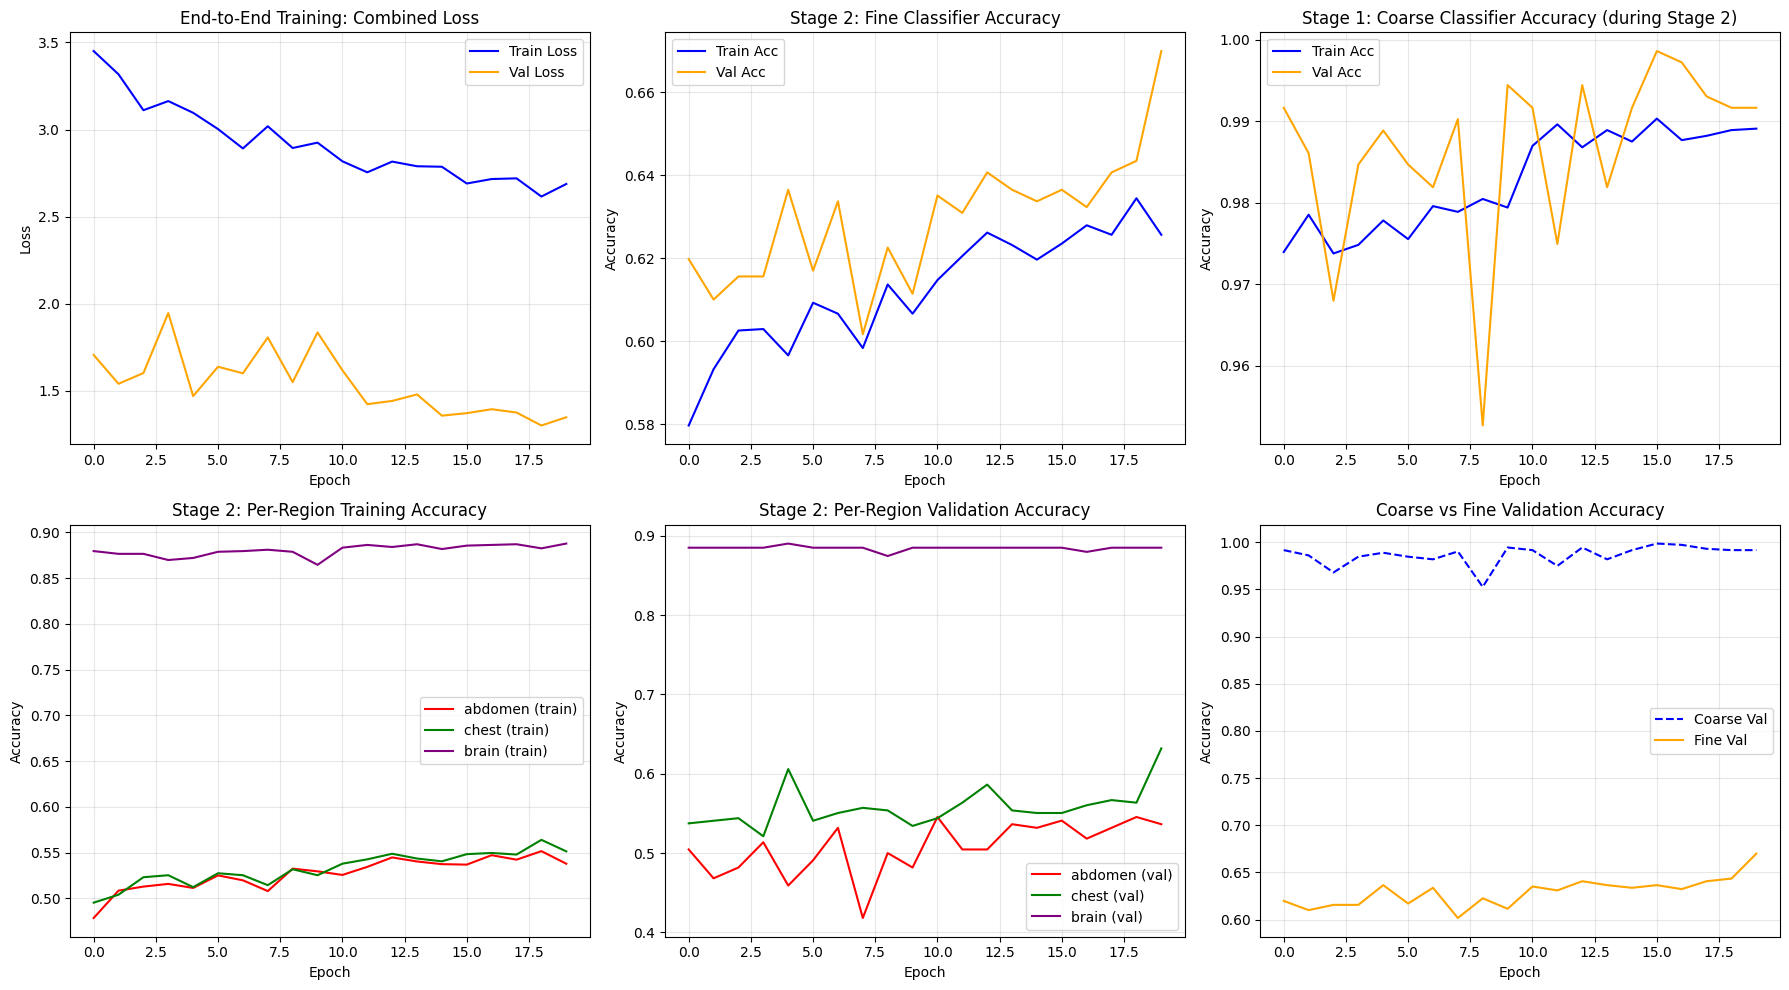

In [11]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Overall Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('End-to-End Training: Combined Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Overall Fine Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[0, 1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Stage 2: Fine Classifier Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Coarse Accuracy (Now also tracked during Stage 2!)
axes[0, 2].plot(history['coarse_train_acc'], label='Train Acc', color='blue')
axes[0, 2].plot(history['coarse_val_acc'], label='Val Acc', color='orange')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_title('Stage 1: Coarse Classifier Accuracy (during Stage 2)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Per-region training accuracy
colors = ['red', 'green', 'purple']
for i, (region_name, accs) in enumerate(history['region_train_acc'].items()):
    axes[1, 0].plot(accs, label=f'{region_name} (train)', color=colors[i % len(colors)])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Stage 2: Per-Region Training Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Per-region validation accuracy
for i, (region_name, accs) in enumerate(history['region_val_acc'].items()):
    axes[1, 1].plot(accs, label=f'{region_name} (val)', color=colors[i % len(colors)])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Stage 2: Per-Region Validation Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Combined comparison
axes[1, 2].plot(history['coarse_val_acc'], label='Coarse Val', color='blue', linestyle='--')
axes[1, 2].plot(history['val_acc'], label='Fine Val', color='orange', linestyle='-')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Coarse vs Fine Validation Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/stage2_fine_training_{MODEL_CONFIG['architecture']}.png", dpi=150)
plt.show()

## 6. Full Hierarchical Evaluation on Test Set

In [12]:
def evaluate_hierarchical_model_end_to_end(model, test_loader, device, dataset_info):
    """Evaluate hierarchical model end-to-end with true routing logic."""
    model.eval()
    
    # Reconstruct region offsets for global label mapping
    region_offsets = {}
    current_offset = 0
    sorted_regions = ['abdomen', 'chest', 'brain'] # Fixed order
    for region in sorted_regions:
        region_offsets[region] = current_offset
        current_offset += dataset_info['region_num_classes'][region]
    
    all_preds_global = []
    all_labels_global = []
    all_probs_global = []
    
    # For consistency metrics
    coarse_preds_all = []
    coarse_labels_all = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="End-to-End Evaluation"):
            if len(batch) == 4:
                imgs, coarse_labels, fine_labels, global_labels_true = batch
            else:
                raise ValueError("DataLoader must return global labels for end-to-end evaluation!")
                
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            # Use forward(return_dict=True) to get all outputs including global logits
            outputs = model(imgs, return_dict=True)
            
            # 1. Coarse Predictions (for analysis/consistency)
            if isinstance(outputs, dict) and 'coarse' in outputs:
                coarse_logits = outputs['coarse']['logits']
                coarse_preds = coarse_logits.argmax(1)
            else:
                # Fallback if return_dict not supported as expected
                coarse_logits = model.forward_coarse(imgs)
                coarse_preds = coarse_logits.argmax(1)

            # Store coarse metrics
            coarse_preds_all.extend(coarse_preds.cpu().numpy())
            coarse_labels_all.extend(coarse_labels.numpy())
            all_labels_global.extend(global_labels_true.numpy())
            
            # 2. Global Fine Predictions (E2E)
            # Organ logits are already routed and zero-padded in forward()
            if isinstance(outputs, dict) and 'fine' in outputs:
                organ_logits = outputs['fine']['logits']
            else:
                organ_logits = outputs # Default return is logits
                
            # Get probabilities and predictions
            probs = torch.softmax(organ_logits, dim=1)
            preds = organ_logits.argmax(dim=1)
            
            all_probs_global.extend(probs.cpu().numpy())
            all_preds_global.extend(preds.cpu().numpy())
                
    return {
        'y_true': np.array(all_labels_global),
        'y_pred': np.array(all_preds_global),
        'y_prob': np.array(all_probs_global),
        'coarse_true': np.array(coarse_labels_all),
        'coarse_pred': np.array(coarse_preds_all)
    }

# Load best model for evaluation
model.load_state_dict(torch.load(save_dir / 'stage2_e2e_model.pth'))

# Evaluate on test set END-TO-END
raw_results = evaluate_hierarchical_model_end_to_end(model, test_loader, DEVICE, dataset_info)

from utils.metrics import compute_comprehensive_metrics

# Compute standardized metrics
class_names = [dataset_info['global_idx_to_name'][i]['name'] for i in range(len(dataset_info['global_idx_to_name']))]

metrics = compute_comprehensive_metrics(
    raw_results['y_true'], 
    raw_results['y_pred'], 
    y_prob=raw_results.get('y_prob'), 
    class_names=class_names
)

# Calculate hierarchy consistency
coarse_correct = (raw_results['coarse_true'] == raw_results['coarse_pred']).sum()
fine_correct = (raw_results['y_true'] == raw_results['y_pred']).sum()
both_correct = ((raw_results['coarse_true'] == raw_results['coarse_pred']) & (raw_results['y_true'] == raw_results['y_pred'])).sum()
coarse_acc = coarse_correct / len(raw_results['y_true'])

predictions_path = save_dir / 'stage2_predictions.json'
with open(predictions_path, 'w') as f:
    json.dump({
        'y_true': raw_results['y_true'].tolist(),
        'y_pred': raw_results['y_pred'].tolist(),
        'labels': class_names
    }, f)
print(f"Predictions saved to: {predictions_path}")

print("\n" + "="*60)
print("FULL HIERARCHICAL END-TO-END TEST RESULTS")
print("="*60)
print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
print(f"Coarse Accuracy:  {coarse_acc:.4f}")
print(f"Consistency (Both Correct): {both_correct / len(raw_results['y_true']):.4f}")
print("\nDetailed Metrics:")
print(f"Precision (Weighted): {metrics['precision_weighted']:.4f}")
print(f"Recall (Weighted):    {metrics['recall_weighted']:.4f}")
print(f"F1-Score (Weighted):  {metrics['f1_weighted']:.4f}")
if 'auc_weighted' in metrics:
    print(f"AUC (Weighted):       {metrics['auc_weighted']:.4f}")   

/tmp/ipykernel_131105/8768136.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_dir / 'stage2_e2e_model.pth'))
End-to-End Evaluation


FULL HIERARCHICAL END-TO-END TEST RESULTS
Overall Accuracy: 0.6038
Coarse Accuracy:  0.9772
Consistency (Both Correct): 0.6038

Detailed Metrics:
Precision (Weighted): 0.5989
Recall (Weighted):    0.6038
F1-Score (Weighted):  0.5561
AUC (Weighted):       0.9503


In [13]:
# Prepare comprehensive metrics
e2e_metrics = {
    "model_type": "hierarchical_end_to_end",
    "architecture": architecture,
    "stage1_accuracy": stage1_info['best_val_accuracy'],
    "end_to_end_metrics": {
        "accuracy": float(metrics.get('accuracy', 0.0)),
        "f1_score": float(metrics.get('f1_weighted', metrics.get('f1_score', 0.0))),
        "precision": float(metrics.get('precision_weighted', metrics.get('precision', 0.0))),
        "recall": float(metrics.get('recall_weighted', metrics.get('recall', 0.0))),
        "auc": float(metrics.get('auc_weighted', metrics.get('auc', 0.0))),
    },
    "training_history": {
        "best_val_acc": float(best_val_acc) if 'best_val_acc' in locals() else None,
        "epochs_trained": len(history['train_loss']) if 'history' in locals() else None
    }
}

# Save metrics
metrics_path = save_dir / 'stage2_e2e_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(e2e_metrics, f, indent=2)
print(f"Stage 2 (E2E) metrics saved to: {metrics_path}")

print(f"\nAll Stage 2 outputs saved to: {save_dir}")


Stage 2 (E2E) metrics saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage2_e2e_metrics.json

All Stage 2 outputs saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d


Table 2: Hierarchical Performance Breakdown



Architecture,Stage 1 Acc (Region),End-to-End Acc (Full System),E2E F1,E2E Precision,E2E Recall,E2E AUC
resnet18_3d,0.9958,0.7098,0.6510,0.6894,0.7098,0.9770
efficientnet3d_b0,0.9930,0.6092,0.5430,0.5325,0.6092,0.9422
densenet121_3d,0.9944,0.6038,0.5561,0.5989,0.6038,0.9503



Table visualization saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/hierarchical_comparison_table.png


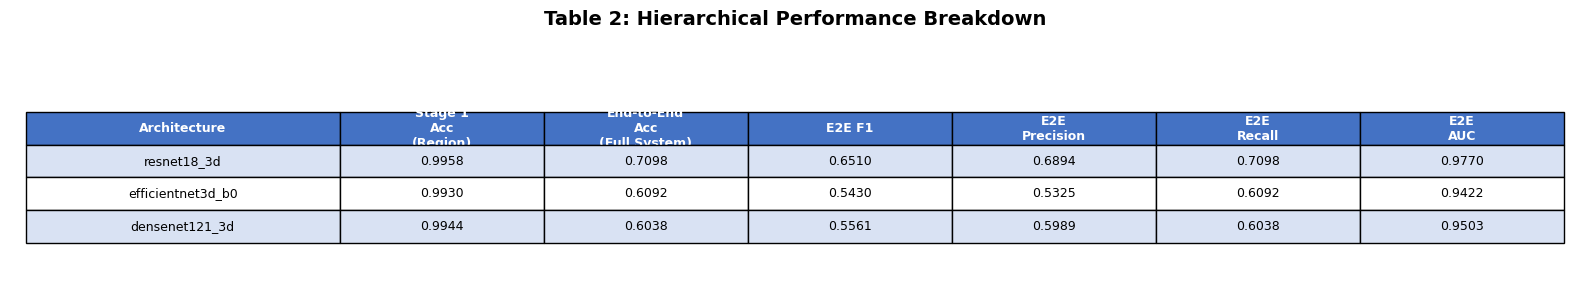

Table data saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/hierarchical_comparison.csv



In [14]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Create hierarchical performance comparison table
print("=" * 80)
print("Table 2: Hierarchical Performance Breakdown")
print("=" * 80)
print()

results_table = []

# List of architectures to compare
architectures = ['efficientnet3d_b0', 'resnet18_3d', 'resnet50_3d', 'densenet121_3d']

for arch in architectures:
    metrics_path = Path(PATHS['models']) / 'hierarchical-classifiers' / arch / 'stage2_e2e_metrics.json'
    
    if metrics_path.exists():
        with open(metrics_path, 'r') as f:
            data = json.load(f)
            
            e2e_metrics = data['end_to_end_metrics']
            
            results_table.append({
                'Architecture': arch,
                'Stage 1\nAcc\n(Region)': data.get('stage1_accuracy', 0.0),
                'End-to-End\nAcc\n(Full System)': e2e_metrics.get('accuracy', 0.0),
                'E2E F1': e2e_metrics.get('f1_score', 0.0),
                'E2E\nPrecision': e2e_metrics.get('precision', 0.0),
                'E2E\nRecall': e2e_metrics.get('recall', 0.0),
                'E2E\nAUC': e2e_metrics.get('auc', 0.0)
            })

if not results_table:
    print("No results found. Please train models first.")
else:
    # Create DataFrame
    df_results = pd.DataFrame(results_table)
    
    # Sort by End-to-End accuracy
    df_results = df_results.sort_values('End-to-End\nAcc\n(Full System)', ascending=False).reset_index(drop=True)
    
    # Display styled pandas table
    styled_df = df_results.style\
        .hide(axis="index")\
        .format({
            'Stage 1\nAcc\n(Region)': '{:.4f}',
            'End-to-End\nAcc\n(Full System)': '{:.4f}',
            'E2E F1': '{:.4f}',
            'E2E\nPrecision': '{:.4f}',
            'E2E\nRecall': '{:.4f}',
            'E2E\nAUC': '{:.4f}'
        })\
        .set_properties(**{'text-align': 'center'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]}
        ])\
        .background_gradient(subset=['End-to-End\nAcc\n(Full System)'], cmap='YlGn', vmin=0.0, vmax=1.0)
    
    display(styled_df)
    
    # Create matplotlib table visualization
    fig, ax = plt.subplots(figsize=(16, max(3, len(df_results) * 0.6 + 1)))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare data for table
    table_data = []
    for idx, row in df_results.iterrows():
        table_data.append([
            row['Architecture'],
            f"{row['Stage 1\nAcc\n(Region)']:.4f}",
            f"{row['End-to-End\nAcc\n(Full System)']:.4f}",
            f"{row['E2E F1']:.4f}",
            f"{row['E2E\nPrecision']:.4f}",
            f"{row['E2E\nRecall']:.4f}",
            f"{row['E2E\nAUC']:.4f}"
        ])
    
    # Create the table
    col_labels = ['Architecture', 'Stage 1\nAcc\n(Region)', 'End-to-End\nAcc\n(Full System)', 
                  'E2E F1', 'E2E\nPrecision', 'E2E\nRecall', 'E2E\nAUC']
    
    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        cellLoc='center',
        loc='center',
        colWidths=[0.20, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.2)
    
    # Style header
    for i in range(7):
        cell = table[(0, i)]
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    colors = ['#D9E2F3', '#FFFFFF']
    for i, row in enumerate(table_data):
        for j in range(7):
            cell = table[(i+1, j)]
            cell.set_facecolor(colors[i % 2])
    
    plt.title('Table 2: Hierarchical Performance Breakdown\n', fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    
    # Save the plot
    plot_path = Path(PATHS['models']) / 'hierarchical-classifiers' / 'hierarchical_comparison_table.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\nTable visualization saved to: {plot_path}")
    plt.show()
    
    # Save as CSV
    csv_path = Path(PATHS['models']) / 'hierarchical-classifiers' / 'hierarchical_comparison.csv'
    df_results.to_csv(csv_path, index=False)
    print(f"Table data saved to: {csv_path}")
    
    print("\n" + "=" * 80)


## 7. Save Final Model Information

In [15]:
def plot_confusion_matrix(y_true, y_pred, title, labels=None, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = len(cm)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    hm = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        square=True,
        cbar=False,
        linewidths=0,
        annot_kws={"size": 10}
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    
    # Add custom colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    vmin = cm.min()
    vmax = cm.max()
    cbar = fig.colorbar(
        hm.collections[0], 
        cax=cax,
        drawedges=False,
        ticks=np.linspace(vmin, vmax, 11)
    )
    cbar.solids.set_edgecolor("face")
    cbar.solids.set_rasterized(False)
    cbar.set_label("Count", fontsize=12)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(size=0, labelsize=10)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold", labelpad=4)
    ax.set_ylabel("True Label", fontsize=12, fontweight="bold", labelpad=4)
    
    # Disable rasterization for all artists
    for artist in fig.findobj():
        if hasattr(artist, "set_rasterized"):
            artist.set_rasterized(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.05, dpi=150)
    
    plt.show()


Plotting confusion matrix for densenet121_3d with 20 classes


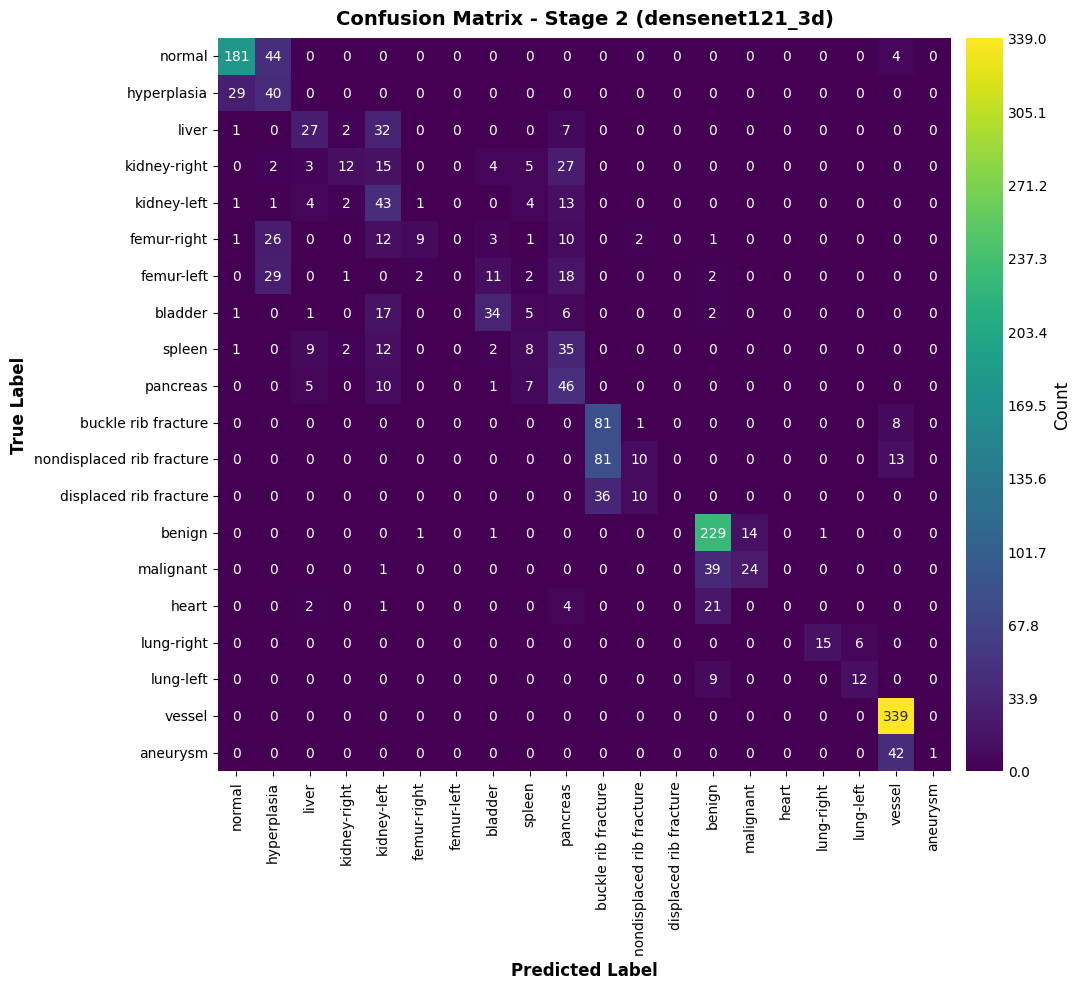

In [16]:
# Import necessary libraries for plotting
import seaborn as sns
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# Prepare stage2_results if not present
if 'stage2_results' not in locals():
    # Use raw_results from the current execution context
    stage2_results = {
        architecture: {
            'labels': raw_results['y_true'],
            'predictions': raw_results['y_pred']
        }
    }

# Ensure output directory exists
os.makedirs(PATHS['figures'], exist_ok=True)

# Stage 2 Confusion Matrices
for arch, results in stage2_results.items():
    # Get all unique labels involved (true and pred) to ensure coverage in confusion matrix
    unique_indices = sorted(list(set(results['labels']) | set(results['predictions'])))
    
    # Generate label names
    if 'dataset_info' in locals() and 'global_idx_to_name' in dataset_info:
        mapping = dataset_info['global_idx_to_name']
        fine_labels_names = [mapping[i]['name'] if i in mapping else str(i) for i in unique_indices]
    else:
        fine_labels_names = [str(i) for i in unique_indices]
    
    print(f"Plotting confusion matrix for {arch} with {len(unique_indices)} classes")
    
    plot_confusion_matrix(
        results['labels'],
        results['predictions'],
        f'Confusion Matrix - Stage 2 ({arch})',
        labels=fine_labels_names,
        save_path=f"{PATHS['figures']}/confusion_fine_{arch}.pgf"
    )

In [ ]:
# Save final model info with standardized metrics
from utils.metrics import save_metrics_json

# Prepare comprehensive info dict
final_info = {
    'model_path': f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth",
    'architecture': MODEL_CONFIG['architecture'],
    'training_mode': 'end-to-end',
    'metrics': metrics,
    'hierarchical_metrics': {
        'coarse_accuracy': float(coarse_acc),
        'consistency_both_correct': float(both_correct / len(raw_results['y_true']))
    }
}

output_path = save_dir / 'stage2_e2e_info.json'
save_metrics_json(final_info, output_path)

print(f"\n Final model info saved to: {output_path}")


Metrics saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage2_e2e_info.json

Final model info saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage2_e2e_info.json
